<a href="https://colab.research.google.com/github/AndlPY/DataPython/blob/main/Photo_Object_Detection(OpenCV%2BYoLo8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U ultralytics opencv-python onnx onnxruntime


  Using cached ultralytics-8.3.192-py3-none-any.whl.metadata (37 kB)
  Using cached onnx-1.19.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (7.0 kB)
  Using cached onnxruntime-1.22.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.9 kB)
  Using cached ultralytics_thop-2.0.17-py3-none-any.whl.metadata (14 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
Using cached ultralytics-8.3.192-py3-none-any.whl (1.1 MB)
Using cached onnx-1.19.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (18.2 MB)
Using cached onnxruntime-1.22.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.5 MB)
Using cached ultralytics_thop-2.0.17-py3-none-any.whl (28 kB)
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)


In [3]:
from ultralytics import YOLO
import numpy as np, cv2, os
from google.colab import files
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
def detect_and_draw(img_bgr, conf=0.25, iou=0.45, imgsz=640, device="cpu",  preview_max_side=720):

    res = model(img_bgr, imgsz=imgsz, conf=conf, iou=iou, device=device)[0]
    vis = res.plot()  # малює бокси/лейбли на копії зображення (BGR)

    #маштабуемо вихідне зображення
    if preview_max_side is not None:
        h, w = vis.shape[:2]
        s = max(h, w)
        if s > preview_max_side:
            scale = preview_max_side / s
            vis = cv2.resize(vis, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

    dets = [  # для логу/збереження
        {
          "cls_id": int(c),
          "cls_name": res.names[int(c)],
          "conf": float(p),
          "xyxy": [int(x) for x in b]
        }
        for b, c, p in zip(res.boxes.xyxy.cpu().numpy(),
                           res.boxes.cls.cpu().numpy(),
                           res.boxes.conf.cpu().numpy())

    ]
    return vis, dets
model = YOLO('yolov8m.pt')
model.export(format='onnx', opset=12)

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
YOLOv8m summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'yolov8m.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)

ONNX: starting export with onnx 1.19.0 opset 12...
ONNX: slimming with onnxslim 0.1.65...
ONNX: export success ✅ 4.7s, saved as 'yolov8m.onnx' (99.0 MB)

Export complete (8.4s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8m.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8m.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8m.onnx'

Saving overmaze.jpg to overmaze.jpg
Image decode ✅

0: 640x480 3 persons, 9 bicycles, 2 motorcycles, 2 backpacks, 1461.6ms
Speed: 3.8ms preprocess, 1461.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)


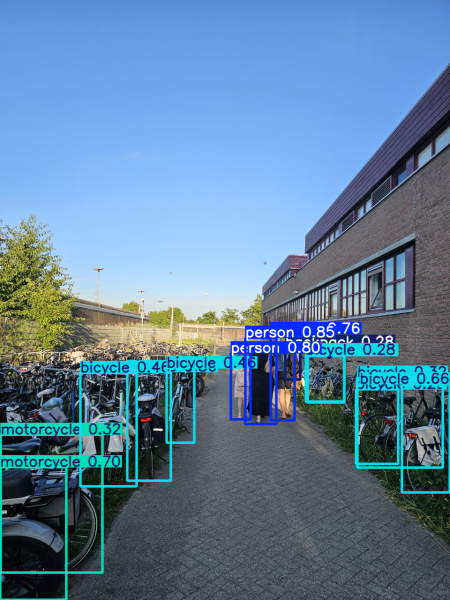

In [13]:
# відкриє кнопку "Choose files"
uploaded = files.upload()

for fname, content in uploaded.items():
    # декодуємо будь-який поширений формат у BGR (без проміжного JPG)
    arr = np.frombuffer(content, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if img is None:
        print(f"[!] File {fname} not found ")
    else:
      print('Image decode ✅')

vis, dets = detect_and_draw(img, preview_max_side=600)                 # 5) запускаємо детекцію й малювання
cv2_imshow(vis)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')